In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import kagglehub
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import os
import glob
import cv2
from PIL import Image

/home/adminnio/miniconda3/envs/navigator/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kumaresanmanickavelu/lyft-udacity-challenge")

print("Path to dataset files:", path)

Path to dataset files: /home/adminnio/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1


In [4]:
from collections import namedtuple

Label = namedtuple('Label', [
    'name',
    'id',
    'trainId',
    'category',
    'categoryId',
    'hasInstances',
    'ignoreInEval',
    'color',
])

labels = [
    Label('Unlabeled',       0, 255, 'void',         0, False, True,  (0, 0, 0)),
    Label('Roads',           1,   0, 'flat',         1, False, False, (128, 64, 128)),
    Label('SideWalks',       2,   1, 'flat',         1, False, False, (244, 35, 232)),
    Label('Building',        3,   2, 'construction', 2, False, False, (70, 70, 70)),
    Label('Wall',            4,   3, 'construction', 2, False, False, (102, 102, 156)),
    Label('Fence',           5,   4, 'construction', 2, False, False, (190, 153, 153)),
    Label('Pole',            6,   5, 'object',       3, False, False, (153, 153, 153)),
    Label('TrafficLight',    7,   6, 'object',       3, False, False, (250, 170, 30)),
    Label('TrafficSign',     8,   7, 'object',       3, False, False, (220, 220, 0)),
    Label('Vegetation',      9,   8, 'nature',       4, False, False, (107, 142, 35)),
    Label('Terrain',        10,   9, 'nature',       4, False, False, (152, 251, 152)),
    Label('Sky',            11,  10, 'sky',          5, False, False, (70, 130, 180)),
    Label('Pedestrian',     12,  11, 'human',        6, True,  False, (220, 20, 60)),
    Label('Rider',          13,  12, 'human',        6, True,  False, (255, 0, 0)),
    Label('Car',            14,  13, 'vehicle',      7, True,  False, (0, 0, 142)),
    Label('Truck',          15,  14, 'vehicle',      7, True,  False, (0, 0, 70)),
    Label('Bus',            16,  15, 'vehicle',      7, True,  False, (0, 60, 100)),
    Label('Train',          17,  16, 'vehicle',      7, True,  False, (0, 80, 100)),
    Label('Motorcycle',     18,  17, 'vehicle',      7, True,  False, (0, 0, 230)),
    Label('Bicycle',        19,  18, 'vehicle',      7, True,  False, (119, 11, 32)),
    Label('Static',         20, 255, 'void',         0, False, True,  (110, 190, 160)),
    Label('Dynamic',        21, 255, 'void',         0, False, True,  (170, 120, 50)),
    Label('Other',          22, 255, 'void',         0, False, True,  (55, 90, 80)),
    Label('Water',          23, 255, 'nature',       4, False, True,  (45, 60, 150)),
    Label('RoadLine',       24, 255, 'flat',         1, False, True,  (157, 234, 50)),
    Label('Ground',         25, 255, 'void',         0, False, True,  (81, 0, 81)),
    Label('Bridge',         26, 255, 'construction', 2, False, True,  (150, 100, 100)),
    Label('RailTrack',      27, 255, 'flat',         1, False, True,  (230, 150, 140)),
    Label('GuardRail',      28, 255, 'construction', 2, False, True,  (180, 165, 180)),
]


In [23]:
#code for Hugging Face Dictionary

# class Cityscape(Dataset):
#     def __init__(self, dcit, transform=None,label_map ='id'):
#         self.transform = transform
#         self.ds = dcit
#         self.label_map = label_map
#         self.id_2_train = {}
#         self.id_2_cat = {}
#         self.trainid_2_name = {}
#         self.train_2_id = {}
#         self.id_2_name = {}
        
#         for lbl in labels:
#             self.id_2_train.update({lbl.id : lbl.trainId})
#             self.id_2_cat.update({lbl.id : lbl.categoryId})
#             if lbl.trainId != 19: # (lbl.trainId > 0) and (lbl.trainId != 255):
#                 self.trainid_2_name.update({lbl.trainId : lbl.name})
#                 self.train_2_id.update({lbl.trainId : lbl.id})
#             if lbl.id > 0:
#                 self.id_2_name.update({lbl.id : lbl.name})
#     def __getitem__(self, idx):
#         label_dict = self.ds['train'][idx]['imageA']
#         mask_dict  = self.ds['train'][idx]['imageB']
        
#         image = Image.open(BytesIO(label_dict['bytes'])).convert("RGB")
#         if self.transform:
#             image = self.transform(image)
            
#         mask_img = Image.open(BytesIO(mask_dict['bytes'])).convert("RGB")
#         mask = np.array(mask_img).astype(np.uint8)
         
#         if self.label_map == 'id':
#             mask[mask==-1] = 0
#         elif self.label_map == 'trainId':
#              for _id, train_id in self.id_2_train.items():  # Fixed: proper variable names
#                 mask[mask == _id] = train_id
#         elif self.label_map == 'categoryId':
#             for _id, cat_id in self.id_2_cat.items():
#                 mask[mask == _id] = cat_id
#          # mask = torch.from_numpy(mask).long()        # mask_tensor =  mask.transform(mask)
#         # sample = {'image' : image, 'mask' : mask }
#         mask = self.transform(mask)
#         return image, mask 
            

#     def __len__(self):
#         return  len(self.ds['train'])

In [24]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(DoubleConv, self).__init__()
      self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
      self.norm = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU(inplace=True)
      self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
      self.norm2 = nn.BatchNorm2d(out_channels)
      self.out = nn.ReLU(inplace=True)

  def forward(self,x):
      x = self.conv1(x)
      x = self.norm(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.norm2(x)
      x = self.out(x)
      return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # After concatenation: out_channels (from upsampling) + out_channels (from skip) = 2*out_channels
        self.conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # Upsample x1

        # Handle size differences
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = TF.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenate skip connection (x2) with upsampled feature (x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class Unet(nn.Module):
    def __init__(self, in_channels, out_channels,features = [32,64,128,256,512]):
        super(Unet,self).__init__()
        self.enc1  = DoubleConv(in_channels,features[0])
        self.Mp1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(features[0],features[1])
        self.Mp2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(features[1],features[2])
        self.Mp3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(features[2],features[3])
        self.Mp4 = nn.MaxPool2d(2)
        self.bottleNeck = DoubleConv(features[3],features[4])
        self.upsample  = UpBlock(features[4],features[3])
        self.upsample2 = UpBlock(features[3],features[2])
        self.upsample3 = UpBlock(features[2],features[1])
        self.upsample4 = UpBlock(features[1],features[0])
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self,x):
        x = self.enc1(x)
        x1 = x
        x = self.Mp1(x)
        x = self.enc2(x)
        x2 = x
        x = self.Mp2(x)
        x = self.enc3(x)
        x3 = x
        x = self.Mp3(x)
        x = self.enc4(x)
        x4 = x
        x = self.Mp4(x)
        x = self.bottleNeck(x)
        x = self.upsample(x,x4)
        x = self.upsample2(x,x3)
        x = self.upsample3(x,x2)
        x = self.upsample4(x,x1)
        x = self.final_conv(x)

        return x

In [25]:
!ls /home/adminnio/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1/dataa/dataA/

CameraRGB  CameraSeg


In [26]:
uconv = Unet(3, 29, [32, 64, 128, 256, 512])
uconv.eval()
test_img = np.ones((1, 3, 128, 128), dtype=np.float32)
test_tensor = torch.tensor(test_img)
output = uconv(test_tensor)
print(output.shape)

# dconv = DoubleConv(3,64)
# test_img = np.ones((1,3,128,128))
# test_tensor = torch.tensor(test_img, dtype=torch.float32)
# output = dconv(test_tensor)
# print(output.shape)

torch.Size([1, 29, 128, 128])


In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [28]:
class Cityscape(Dataset):
    def __init__(self, root_dir, transform=None, label_map='id'):
        self.transform = transform
        self.label_map = label_map
        self.root_dir = root_dir

        # Initialize mappings
        self.id_2_train = {}
        self.id_2_cat = {}
        self.trainid_2_name = {}
        self.train_2_id = {}
        self.id_2_name = {}
        self.color_to_id = {} # Added back for completeness, though not strictly needed if masks are grayscale

        # Populate mappings from labels
        for lbl in labels:
            self.id_2_train[lbl.id] = lbl.trainId
            self.id_2_cat[lbl.id] = lbl.categoryId
            if lbl.trainId != 255: # Only map valid trainIds to names
                self.trainid_2_name[lbl.trainId] = lbl.name
                self.train_2_id[lbl.trainId] = lbl.id
            if lbl.id > 0: # Only map valid IDs to names
                self.id_2_name[lbl.id] = lbl.name
            
            # Populate color_to_id mapping (useful if masks were RGB, but you confirmed grayscale)
            if hasattr(lbl, 'color') and lbl.color is not None:
                self.color_to_id[lbl.color] = lbl.id

        # Use glob.glob() correctly
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, 'CameraRGB', '*.png')))
        self.mask_paths = sorted(glob.glob(os.path.join(root_dir, 'CameraSeg', '*.png')))

        if len(self.image_paths) == 0:
            raise FileNotFoundError(f"No images found in {os.path.join(root_dir, 'CameraRGB')}. Check your path.")
        if len(self.mask_paths) == 0:
            raise FileNotFoundError(f"No masks found in {os.path.join(root_dir, 'CameraSeg')}. Check your path.")
        if len(self.image_paths) != len(self.mask_paths):
            raise ValueError(f"Mismatch in number of images ({len(self.image_paths)}) and masks ({len(self.mask_paths)}).")

    def __getitem__(self, idx):
        # 1. Load Image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB") # Convert to RGB for consistency

        # 2. Load Mask
        mask_path = self.mask_paths[idx]
        # Since you confirmed masks are grayscale, load them as 'L' (8-bit pixels, grayscale)
        mask_img = Image.open(mask_path).convert("L")
        mask_np = np.array(mask_img).astype(np.uint8) # Convert to NumPy array for manipulation

        # 3. Apply Label Mapping
        if self.label_map == 'id':
            mask_np[mask_np == 255] = 0 
            pass 

        elif self.label_map == 'trainId':
            # Create a temporary array to store the mapped values to avoid modifying in-place
            # This is safer than directly modifying `mask_np` in a loop, especially with `np.where`
            mapped_mask_np = np.full_like(mask_np, fill_value=255, dtype=np.uint8) # Default to 255 (ignore)

            # Iterate through unique values in mask_np to map them
            # This is generally more efficient than iterating through all `labels`
            unique_ids = np.unique(mask_np)
            for _id in unique_ids:
                if _id in self.id_2_train:
                    mapped_mask_np[mask_np == _id] = self.id_2_train[_id]
                else:
                    # If an ID from the mask is not in your label map, it defaults to 255 (ignore)
                    mapped_mask_np[mask_np == _id] = 255 # Or whatever your ignore_index is
            mask_np = mapped_mask_np

        elif self.label_map == 'categoryId':
            mapped_mask_np = np.full_like(mask_np, fill_value=255, dtype=np.uint8)
            unique_ids = np.unique(mask_np)
            for _id in unique_ids:
                if _id in self.id_2_cat:
                    mapped_mask_np[mask_np == _id] = self.id_2_cat[_id]
                else:
                    mapped_mask_np[mask_np == _id] = 255
            mask_np = mapped_mask_np
        else:
            raise ValueError(f"Invalid label_map: {self.label_map}. Choose 'id', 'trainId', or 'categoryId'.")

        # 4. Convert Mask to PyTorch LongTensor
        # This should be the final step for the mask.
        mask_tensor = torch.from_numpy(mask_np).long()

        # 5. Apply Image Transforms
        if self.transform:
            # Assuming self.transform is for image (e.g., Resize, ToTensor, Normalize)
            image = self.transform(image)
            # If your transform also needs to resize the mask, you'd do it here
            # using interpolation=transforms.InterpolationMode.NEAREST
            # Example:
            # if 'Resize' in str(type(self.transform)): # Simple check, better to pass target size
            #     target_size = image.shape[-2:] # Assuming image is (C, H, W) after transform
            #     mask_tensor = transforms.Resize(target_size, interpolation=transforms.InterpolationMode.NEAREST)(mask_tensor.unsqueeze(0)).squeeze(0)

        return image, mask_tensor

    def __len__(self):
        return len(self.image_paths)

In [29]:
path = "/home/adminnio/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1/dataa/dataA/"
dataset = Cityscape(path,  transform=transform)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = Unet(3, 35, [32, 64, 128, 256, 512])
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore unlabeled pixels if you use -1
optimizer = optim.Adam(model.parameters(), lr=1e-3)

AttributeError: 'Tensor' object has no attribute 'trainId'

In [30]:
img,label = next(iter(data_loader))
img_np = img[0].cpu().numpy() 
print(np.shape(label))

torch.Size([8, 600, 800])


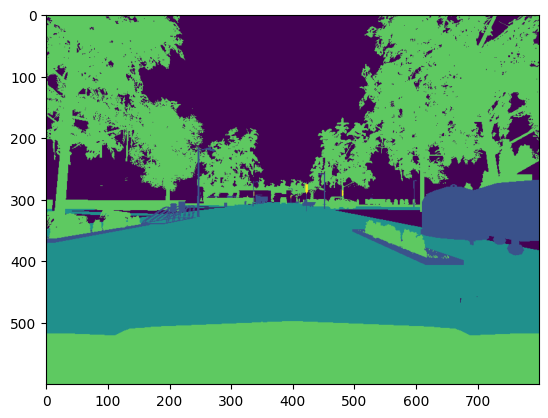

In [12]:
img_np = img[0].cpu().numpy()
np.shape(label[1])
label_np = label[1].cpu().numpy() 
plt.imshow(label_np)
img_np = np.transpose(img_np, (1, 2, 0))



In [13]:
# After dataset initialization
print("First 5 ID to TrainID mappings:", list(dataset.id_2_train.items())[:40])
print("TrainID to Name:", dataset.trainid_2_name)
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128

First 5 ID to TrainID mappings: [(0, 255), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 255), (21, 255), (22, 255), (23, 255), (24, 255), (25, 255), (26, 255), (27, 255), (28, 255)]
TrainID to Name: {0: 'Roads', 1: 'SideWalks', 2: 'Building', 3: 'Wall', 4: 'Fence', 5: 'Pole', 6: 'TrafficLight', 7: 'TrafficSign', 8: 'Vegetation', 9: 'Terrain', 10: 'Sky', 11: 'Pedestrian', 12: 'Rider', 13: 'Car', 14: 'Truck', 15: 'Bus', 16: 'Train', 17: 'Motorcycle', 18: 'Bicycle'}


In [14]:
print(torch.cuda.memory_summary())
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  30386 KiB |  30386 KiB |  30386 KiB |      0 B   |
|       from large pool |  27392 KiB |  27392 KiB |  27392 KiB |      0 B   |
|       from small pool |   2994 KiB |   2994 KiB |   2994 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |  30386 KiB |  30386 KiB |  30386 KiB |      0 B   |
|       from large pool |  27392 KiB |  27392 KiB |  27392 KiB |

In [16]:
dir_path = "/media/adminnio/Volume/Data/Datasets/Corals/models/weights"
os.makedirs(dir_path, exist_ok=True) 
PATH = os.path.join(dir_path, "model_weights.pth")
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
print("loaded model")

loaded model


In [72]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import torch
torch.cuda.empty_cache()
epochs=100
verbose =1
model.train()
for epoch in range(epochs):
        running_loss = 0.0
        total_batches = len(data_loader)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        # tqdm progress bar over batches
        progress_bar = tqdm(enumerate(data_loader), total=total_batches, leave=False)
        for batch_idx, (images, masks) in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss / (batch_idx + 1)
            progress_bar.set_description(f"Batch {batch_idx+1}/{total_batches}")
            progress_bar.set_postfix(loss=f"{avg_loss:.4f}")

        epoch_loss = running_loss / total_batches
        print(f"Epoch {epoch+1} finished. Average Loss: {epoch_loss:.4f}")



Epoch 1/100
------------------------------


KeyboardInterrupt: 

In [17]:
def inference(model, dataloader, device):
    model.to(device)
    model.eval()
    
    preds = []
    with torch.no_grad():
        for images, _ in dataloader:  # Ignore labels during inference
            images = images.to(device)  # (N, 3, H, W)
            
            outputs = model(images)      # (N, 35, H, W)
            
            # Get predicted class per pixel (argmax over class dim)
            predicted_masks = torch.argmax(outputs, dim=1)  # (N, H, W)
            
            preds.append(predicted_masks.cpu())
    
    # Concatenate all predictions
    preds = torch.cat(preds, dim=0)
    return preds

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predicted_masks = inference(model, data_loader, device)

print(f"Predicted masks shape: {predicted_masks.shape}")  # (num_samples, H, W)


Predicted masks shape: torch.Size([1000, 600, 800])


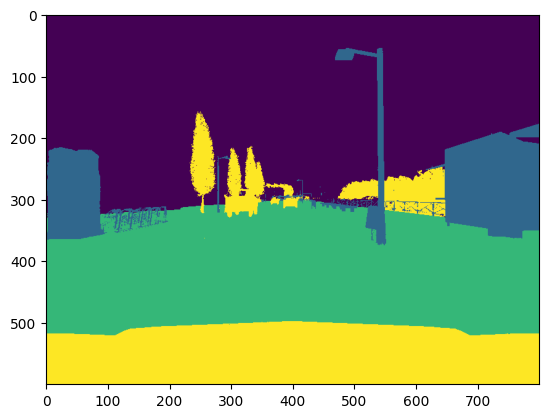

In [19]:
label_np = predicted_masks[1].cpu().numpy() 
plt.imshow(label_np)
img_np = np.transpose(img_np, (1, 2, 0))


In [20]:
np.shape(predicted_masks)

torch.Size([1000, 600, 800])

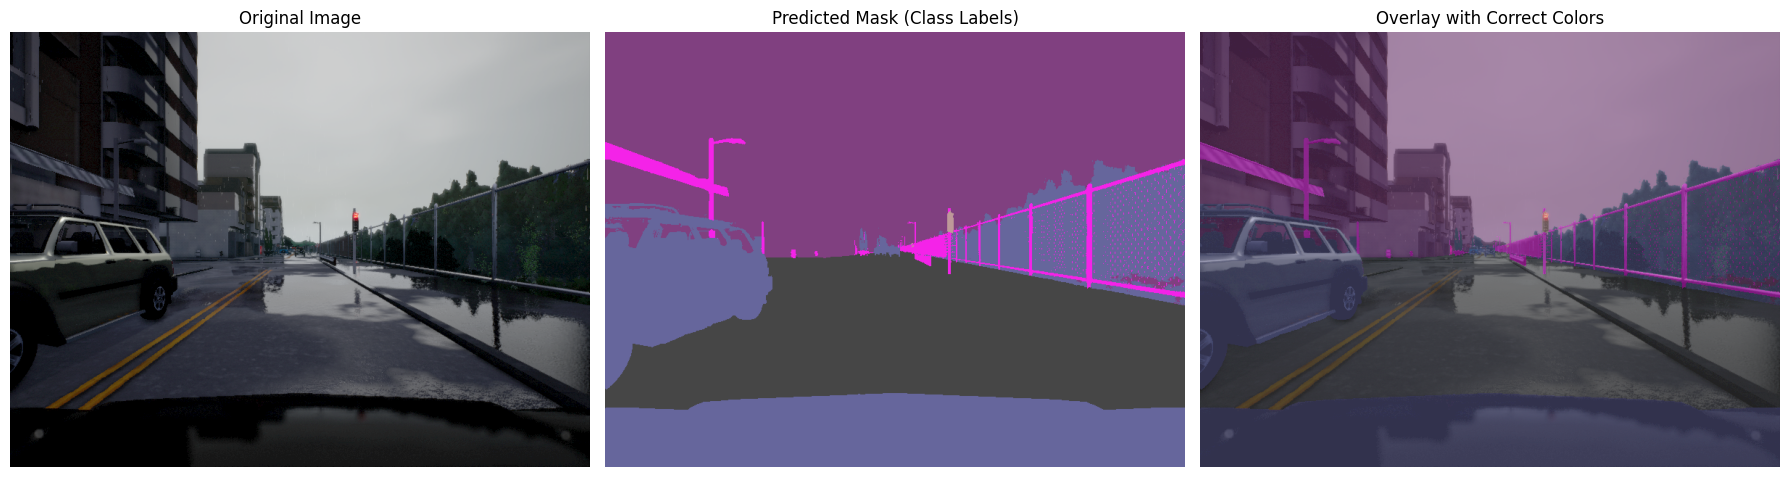

In [21]:
num_classes = 35  # Number of classes expected from your model output
color_map = np.zeros((num_classes, 3), dtype=np.uint8)
for label in labels:
    if label.trainId != 255:
        color_map[label.trainId] = label.color

# Load your image
img_path = "/home/adminnio/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1/dataa/dataA/CameraRGB/02_00_000.png"
img_pil = Image.open(img_path).convert("RGB")

# Your transform (make sure you define it, e.g. torchvision.transforms)
# Example:
import torchvision.transforms as T
transform = T.Compose([
    T.Resize((600, 800)),
    T.ToTensor(),
    # add normalization if needed, matching your training
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Prepare image tensor
img_tensor = transform(img_pil).unsqueeze(0).to(device)  # (1, C, H, W)

with torch.no_grad():
    output = model(img_tensor)  # Output shape: [1, num_classes, H, W]

# Convert output logits to predicted class indices
class_map = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()  # (H, W)

# Map class indices to colors
color_mask = color_map[class_map]  # (H, W, 3) uint8

# Normalize for matplotlib display (0-1 float)
color_mask_norm = color_mask.astype(np.float32) / 255.0

# Resize original image for display
img_resized = img_pil.resize((800, 600))
img_np = np.array(img_resized).astype(np.float32) / 255.0

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img_np)
axs[0].set_title("Original Image")

axs[1].imshow(color_mask_norm,  vmin=0, vmax=num_classes-1)
axs[1].set_title("Predicted Mask (Class Labels)")

axs[2].imshow(img_np)
axs[2].imshow(color_mask_norm, alpha=0.5)
axs[2].set_title("Overlay with Correct Colors")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00,  9.85it/s]

Final Mean Loss: 0.0296
Final Mean IoU: 0.8455


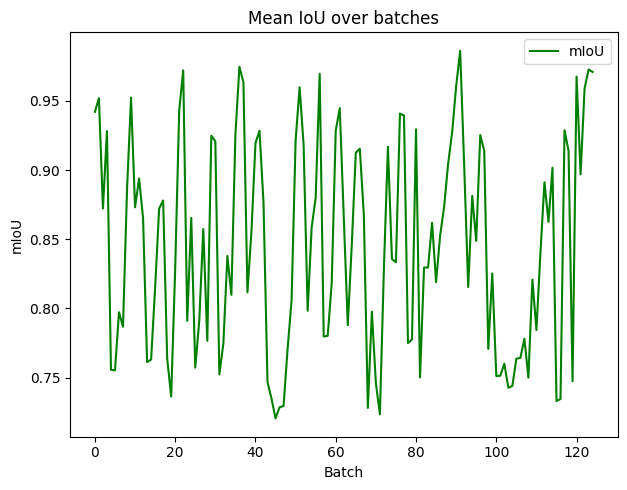

In [22]:
evalpath = "/home/adminnio/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1/datab/dataB/"
dataset_eval = Cityscape(evalpath, transform=transform)
data_loader_eval = DataLoader(dataset_eval, batch_size=8, shuffle=False, num_workers=4)
model.to(device)
model.eval()
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)  # or your ignore label
def compute_iou(pred, target, num_classes=35, ignore_index=255):
    """
    pred: (N, H, W) predicted labels
    target: (N, H, W) ground truth labels
    Returns: IoU for each class, ignoring ignore_index
    """
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # no ground truth for this class in batch
        else:
            ious.append(intersection / union)
    return ious

losses = []
miou_list = []

with torch.no_grad():
    for images, labels in tqdm(data_loader_eval, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # shape (N, num_classes, H, W)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        preds = torch.argmax(outputs, dim=1)  # (N, H, W)
        ious = compute_iou(preds, labels)
        # mean IoU ignoring NaNs:
        miou = np.nanmean(ious)
        miou_list.append(miou)

# Final metrics
mean_loss = np.mean(losses)
mean_miou = np.mean(miou_list)

print(f"Final Mean Loss: {mean_loss:.4f}")
print(f"Final Mean IoU: {mean_miou:.4f}")

plt.figure(figsize=(12,5))



plt.subplot(1, 2, 2)
plt.plot(miou_list, label='mIoU', color='green')
plt.xlabel('Batch')
plt.ylabel('mIoU')
plt.title('Mean IoU over batches')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
dir_path = "/media/adminnio/Volume/Data/Datasets/Corals/models/weights"
os.makedirs(dir_path, exist_ok=True) 
PATH = os.path.join(dir_path, "model_weights.pth")
torch.save(model.state_dict(), PATH)
